In [76]:
import requests
import os
import time
from collections import Counter
import matplotlib.pyplot as plt

API_KEY = os.environ['API_KEY']
page_limit = 10000

---


In [77]:
def get_budget():
    api_url = f'https://api.blockchair.com/premium/stats?key={API_KEY}'
    request = requests.get(api_url)
    if request.status_code != 200:
        print(f'Error {request.status_code}')
    else:
        return request.json()

def get_address(address_hash, offset):
    api_url = f'https://api.blockchair.com/bitcoin/dashboards/address/{address_hash}?limit={page_limit},0&offset={offset}&transaction_details=true&key={API_KEY}'
    request = requests.get(api_url)
    if request.status_code == 500:
        time.sleep(10)
        get_address(address_hash, offset)
    if request.status_code != 200:
        print(f'Error {request.status_code}')
    else:
        return request.json()

def get_multi_txn(txn_hash):
    api_url = f'https://api.blockchair.com/bitcoin/dashboards/transactions/{txn_hash}?key={API_KEY}'
    request = requests.get(api_url)
    if request.status_code != 200:
        print(f'Error {request.status_code}')
    else:
        return request.json()

def get_full_transactions(address):
    address_hash = list(address['data'])[0]
    txn = get_transactions(address)
    n_tx = transaction_count(address)

    if n_tx > 10000:
        for i in range(1,n_tx//page_limit+1):
            offset = i*10000
            address = get_address(address_hash, offset)
            txn += get_transactions(address)
    return txn

def transaction_count(address):
    address_hash = list(address['data'])[0]
    return address['data'][address_hash]['address']['transaction_count']

def last_receive(address):
    address_hash = list(address['data'])[0]
    return address['data'][address_hash]['address']['last_seen_receiving']

def last_spent(address):
    address_hash = list(address['data'])[0]
    return address['data'][address_hash]['address']['last_seen_spending']

def get_transactions(address):
    address_hash = list(address['data'])[0]
    return address['data'][address_hash]['transactions']

def get_inputs(full_txn):
    return full_txn['data'][txn_hash]['inputs']

def get_outputs(full_txn):
    return full_txn['data'][txn_hash]['outputs']

In [78]:
root_hash = 'bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97'

# retrieve address information first
address = get_address(root_hash,0)
# get a list of all transactions for an address
txns = get_full_transactions(address)
# Make graph object with address, 0 or vice versa
G = {d['hash']: (0, root_hash)  if d['balance_change'] > 0 else (root_hash, 0)  for d in txns}
# Partition into lists of 10 for API limitation
list_of_txn_hashes = list(G)
partitioned_txn = [list_of_txn_hashes[i:i+10] for i in range(0, len(G), 10)]
# for each list of 10 transform into API call
multi_transaction_hash = [','.join(partitioned_txn[n]) for n, _ in enumerate(partitioned_txn)]

# retrieve detailed transactions in batches of 10
for multi_txn in multi_transaction_hash:
    detailed_transactions = get_multi_txn(multi_txn)
    txn_hash_list = multi_txn.split(',')
    
    # For root address we retrieve outgoing transactions
    for txn_hash in txn_hash_list:
        # if main address is receiving set inputs
        if G[txn_hash][0] == 0:
            del G[txn_hash]
            # inputs = get_inputs(detailed_transactions)
            # G[txn_hash] = (set(i['recipient'] for i in inputs), G[txn_hash][1])
        else:
            # else set outputs
            outputs = get_outputs(detailed_transactions)
            G[txn_hash] = (G[txn_hash][0], set(i['recipient'] for i in outputs if i['recipient'] != root_hash))

# get non-empty recipient nodes
G = {key: value for key, value in G.items() if value[1]}
queue = [value[1] for value in G.values()]

# Count the frequency of the hashes
hash_counts = Counter(hash for hash_set in queue for hash in hash_set)
queue = list(hash_counts.keys())

In [79]:
# while queue:
root_hash = queue[0]
# retrieve address information first
address = get_address(root_hash,0)
# get a list of all transactions for an address
txns = get_full_transactions(address)
# Make graph object with address, 0 or vice versa
temp = {d['hash']: (0, root_hash)  if d['balance_change'] > 0 else (root_hash, 0)  for d in txns}
# Partition into lists of 10 for API limitation
list_of_txn_hashes = [i['hash'] for i in txns]
partitioned_txn = [list_of_txn_hashes[i:i+10] for i in range(0, len(list_of_txn_hashes), 10)]
# for each list of 10 transform into API call
multi_transaction_hash = [','.join(partitioned_txn[n]) for n, _ in enumerate(partitioned_txn)]


# retrieve detailed transactions in batches of 10
for multi_txn in multi_transaction_hash:
    detailed_transactions = get_multi_txn(multi_txn)
    txn_hash_list = multi_txn.split(',')
    
    # For root address we retrieve outgoing transactions
    for txn_hash in txn_hash_list:
        # if main address is receiving set inputs
        if temp[txn_hash][0] == 0:
            inputs = get_inputs(detailed_transactions)
            temp[txn_hash] = (set(i['recipient'] for i in inputs), temp[txn_hash][1])
        else:
            # else set outputs
            outputs = get_outputs(detailed_transactions)
            temp[txn_hash] = (temp[txn_hash][0], set(i['recipient'] for i in outputs if i['recipient'] != root_hash))

# get non-empty recipient nodes
G.update({key: value for key, value in temp.items() if value[1]})
queue = [value[1] for value in temp.values()]

# Count the frequency of the hashes
hash_counts = Counter(hash for hash_set in queue for hash in hash_set)
queue = list(hash_counts.keys())


    # break

In [75]:
import networkx as nx

data  = list(G.values())

# loop through each tuple in the list
# for item in node_edge_list:
#     if isinstance(item[0], set):
#         G.add_nodes_from(item[0])
#         G.add_edge(*item)
#     else:
#         G.add_node(item[0])
#         G.add_nodes_from(item[1])
#         G.add_edges_from([(item[0], node) for node in item[1]])


AttributeError: 'Graph' object has no attribute 'values'

In [ ]:
nodes = [item[0] for item in data]
edges = [(item[0], node) for item in data for node in item[1] if isinstance(item[1], set)]




In [71]:
nodes

{'3JZq4atUahhuA9rLhXLMhhTo133J9rF97j'}

In [58]:
GRAPH.add_nodes_from(nodes)

bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97
bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvq

In [80]:
node_data = [(i, {"label": f"Node {i}"}) for i in range(100)]
edge_data = [(i, i+1) for i in range(99)]

In [81]:
print(node_data)

[(0, {'label': 'Node 0'}), (1, {'label': 'Node 1'}), (2, {'label': 'Node 2'}), (3, {'label': 'Node 3'}), (4, {'label': 'Node 4'}), (5, {'label': 'Node 5'}), (6, {'label': 'Node 6'}), (7, {'label': 'Node 7'}), (8, {'label': 'Node 8'}), (9, {'label': 'Node 9'}), (10, {'label': 'Node 10'}), (11, {'label': 'Node 11'}), (12, {'label': 'Node 12'}), (13, {'label': 'Node 13'}), (14, {'label': 'Node 14'}), (15, {'label': 'Node 15'}), (16, {'label': 'Node 16'}), (17, {'label': 'Node 17'}), (18, {'label': 'Node 18'}), (19, {'label': 'Node 19'}), (20, {'label': 'Node 20'}), (21, {'label': 'Node 21'}), (22, {'label': 'Node 22'}), (23, {'label': 'Node 23'}), (24, {'label': 'Node 24'}), (25, {'label': 'Node 25'}), (26, {'label': 'Node 26'}), (27, {'label': 'Node 27'}), (28, {'label': 'Node 28'}), (29, {'label': 'Node 29'}), (30, {'label': 'Node 30'}), (31, {'label': 'Node 31'}), (32, {'label': 'Node 32'}), (33, {'label': 'Node 33'}), (34, {'label': 'Node 34'}), (35, {'label': 'Node 35'}), (36, {'labe

In [82]:
print(edge_data)

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 88), (88, 89), (89, 90), (90, 91), (91, 92), (92, 93), (93, 94), (94, 95), (95, 96), (96, 97), (97, 98), (98, 99)]


In [89]:
G = nx.Graph()
G.add_edges_from(edge_data)

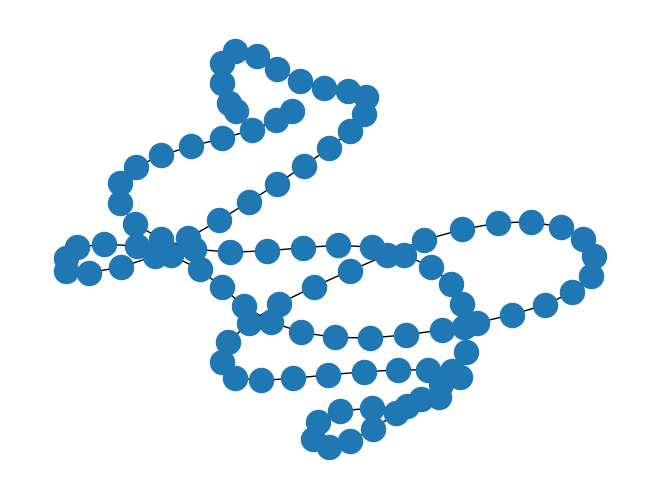

In [91]:
nx.draw(G)